<a href="https://colab.research.google.com/github/ayoub-odegard/data/blob/main/projet_IT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install tensorflow==1.13.1

In [ ]:
!pip install keras==2.1.0

In [ ]:
!git clone https://github.com/matterport/Mask_RCNN

In [ ]:
!git clone https://github.com/ayoub-odegard/

In [ ]:
!wget https://github.com/matterport/Mask_RCNN/releases/download/v2.0/mask_rcnn_coco.h5

In [ ]:
!unzip /content/data.zip

In [ ]:
!unzip /content/logs.zip

In [29]:
!touch /content/CandT_model.py

In [ ]:
!pip install h5py==2.10.0

In [32]:
!python CandT_model.py

/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:526: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint8 = np.dtype([("qint8", np.int8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:527: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_quint8 = np.dtype([("quint8", np.uint8, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:528: FutureWarning: Passing (type, 1) or '1type' as a synonym of type is deprecated; in a future version of numpy, it will be understood as (type, (1,)) / '(1,)type'.
  _np_qint16 = np.dtype([("qint16", np.int16, 1)])
/usr/local/lib/python3.7/dist-packages/tensorflow/python/framework/dtypes.py:529: FutureWarning: Passing (type, 1) or 

In [33]:
mv /content/Mask_RCNN/logs /content/logs

In [34]:
import warnings
warnings.filterwarnings('ignore')
import os
import sys
import json
import datetime
import numpy as np
import skimage.draw
import cv2
import random
import math
import re
import time
import tensorflow as tf
import matplotlib.pyplot as plt
import matplotlib.patches as patches
import matplotlib.image as mpimg
sys.path.append("/content/Mask_RCNN")
from mrcnn import utils
from mrcnn import visualize
from mrcnn.visualize import display_images
from mrcnn.visualize import display_instances
import mrcnn.model as modellib
from mrcnn.model import log
from mrcnn.config import Config
from mrcnn import model as modellib, utils


class CustomConfig(Config):
    """Configuration for training on the custom  dataset.
    Derives from the base Config class and overrides some values.
    """
    # Give the configuration a recognizable name
    NAME = "object"
    GPU_COUNT = 1
    IMAGES_PER_GPU = 1

    NUM_CLASSES = 1 + 2  # Background + Car and truck

    # Number of training steps per epoch
    STEPS_PER_EPOCH = 10

    # Skip detections with < 90% confidence
    DETECTION_MIN_CONFIDENCE = 0.9

Using TensorFlow backend.

In [35]:
# Code for Customdataset class. Same code is present in CandT.py file also
class CustomDataset(utils.Dataset):

    def load_custom(self, dataset_dir, subset):

        self.add_class("object", 1, "simple_tree")
        self.add_class("object", 2, "apple_tree")


        assert subset in ["train", "val"]
        dataset_dir = os.path.join(dataset_dir, subset)
        if subset == "train":
            annotations1 = json.load(open('/content/data/train/train_annotation.json'))
        else :
            annotations1 = json.load(open('/content/data/val/validation_annotation.json'))


        annotations = list(annotations1.values())  # don't need the dict keys

        annotations = [a for a in annotations if a['regions']]
        
        # Add images
        for a in annotations:
           
            polygons = [r['shape_attributes'] for r in a['regions']] 
            objects = [s['region_attributes']['names'] for s in a['regions']]
            print("objects:",objects)
            name_dict = {"simple_tree": 1,"tab": 2,"apple_tree": 3}
            num_ids = [name_dict[a] for a in objects]

            print("numids",num_ids)
            image_path = os.path.join(dataset_dir, a['filename'])
            image = skimage.io.imread(image_path)
            height, width = image.shape[:2]

            self.add_image(
                "object", 
                image_id=a['filename'],  # use file name as a unique image id
                path=image_path,
                width=width, height=height,
                polygons=polygons,
                num_ids=num_ids
                )

    def load_mask(self, image_id):
       
        image_info = self.image_info[image_id]
        if image_info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)

        info = self.image_info[image_id]
        if info["source"] != "object":
            return super(self.__class__, self).load_mask(image_id)
        num_ids = info['num_ids']
        mask = np.zeros([info["height"], info["width"], len(info["polygons"])],
                        dtype=np.uint8)
        for i, p in enumerate(info["polygons"]):

        	rr, cc = skimage.draw.polygon(p['all_points_y'], p['all_points_x'])

        	mask[rr, cc, i] = 1

        num_ids = np.array(num_ids, dtype=np.int32)
        return mask, num_ids #np.ones([mask.shape[-1]], dtype=np.int32)

    def image_reference(self, image_id):
        """Return the path of the image."""
        info = self.image_info[image_id]
        if info["source"] == "object":
            return info["path"]
        else:
            super(self.__class__, self).image_reference(image_id)

In [10]:
# Inspect the model in training or inference modes values: 'inference' or 'training'
TEST_MODE = "inference"
ROOT_DIR = "/content/data"

def get_ax(rows=1, cols=1, size=16):
  """Return a Matplotlib Axes array to be used in all visualizations in the notebook.  Provide a central point to control graph sizes. Adjust the size attribute to control how big to render images"""
  _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
  return ax



# Load validation dataset
# Must call before using the dataset
CUSTOM_DIR = "/content/data"
dataset = CustomDataset()
dataset.load_custom(CUSTOM_DIR, "val")
dataset.prepare()
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

objects: ['simple_tree']
numids [1]
objects: ['simple_tree']
numids [1]
objects: ['simple_tree']
numids [1]
objects: ['apple_tree']
numids [3]
Images: 4
Classes: ['BG', 'simple_tree', 'apple_tree']


In [36]:
ROOT_DIR = "/content"

DEFAULT_LOGS_DIR = os.path.join(ROOT_DIR, "logs")

MODEL_DIR = os.path.join(ROOT_DIR, "logs")

config = CustomConfig()
#LOAD MODEL. Create model in inference mode
model = modellib.MaskRCNN(mode="inference", model_dir=MODEL_DIR, config=config)

In [40]:
WEIGHTS_PATH = "/content/logs/object20220206T2155/mask_rcnn_object_0004.h5"   


In [41]:
# Load COCO weights Or, load the last model you trained
weights_path = WEIGHTS_PATH
# Load weights
print("Loading weights ", weights_path)
model.load_weights(weights_path, by_name=True)

Loading weights  /content/logs/object20220206T2155/mask_rcnn_object_0004.h5
Re-starting from epoch 4


Images: 4
Classes: ['BG', 'simple_tree', 'apple_tree']
1
Processing 1 images
image                    shape: (689, 900, 3)         min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  150.10000  float64
image_metas              shape: (1, 15)               min:    0.00000  max: 1024.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


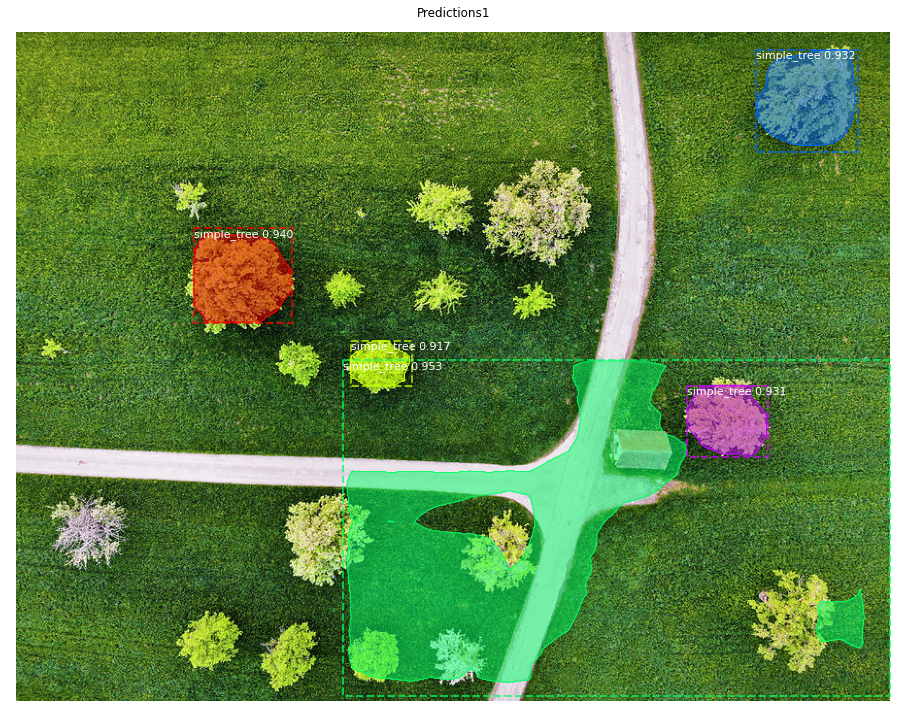

In [43]:
print("Images: {}\nClasses: {}".format(len(dataset.image_ids), dataset.class_names))

# This is for predicting images which are not present in dataset

image1 = mpimg.imread("/content/16.jpg")

# Run object detection
print(len([image1]))

results1 = model.detect([image1], verbose=1)

# Display results
ax = get_ax(1)
r1 = results1[0]
visualize.display_instances(image1, r1['rois'], r1['masks'], r1['class_ids'],dataset.class_names, r1['scores'], ax=ax, title="Predictions1")

